In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


experiment_name = "baseline.classifier.mine_retinas"
data_path = "./data/sig56/"

reference_df_path = "data/decays/long_ks_counts_56.csv"


output_path = os.path.join("data",experiment_name)

try:
    os.mkdir(output_path)
except:
    pass

/home/jheuristic/yozhik/ksfinder


In [2]:
#import theano stack
%env THEANO_FLAGS="device=gpu2"

import lasagne
import theano
import theano.tensor as T
from lib.retina_compiled import retinize_events

floatX = theano.config.floatX


env: THEANO_FLAGS="device=gpu2"


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '24668' (I am process '3199')
Using gpu device 2: Tesla K40m (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 4004.)


## Preprocess/Load data

In [3]:
from lib.retina_compiled import retina_view
def random_retina(seed =None, xdim=32,ydim=32, dalpha = np.pi/3,dbeta = np.pi/3,return_params = True):
    np.random.seed(seed)
    x0 = np.random.normal(0,1000)
    y0 = np.random.normal(0,1000)
    z0 = np.random.uniform(-100,15000)
    
    z_c = np.random.uniform(z0-3000,z0+3000)
    alpha = np.arctan(-x0/(z_c-z0))
    beta = np.arctan(-y0/(z_c-z0))
    
    
    sigma = np.random.choice([10,50,75,100,250,500])
    
    retina = retina_view(x0,y0,z0,alpha,beta,sigma,
                                xdim,ydim,dalpha,dbeta)
    params = x0,y0,z0,alpha,beta,sigma,xdim,ydim,dalpha,dbeta
    return retina if not return_params else retina,params


In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from collections import OrderedDict


def evaluate_retinas(X_retinas,y,verbose = True,test_size=0.25,cv=10):
    """evaluates retinas individually by training logistic regression on them.
    X_retinas - a list of [n_samples,*] for each retina
    y - classification target
    verbose - whether to print progress
    test_size = what fraction of X to take as a final test
    cv = how many folds to crossvalidate when setting up regularizer for logistic regression
    returns: list of dicts of metrics of Accuracy and Auc on train and test"""
    results = []

    for r_i in range(len(X_retinas)):
        
        print "processing retina",r_i
        
        X_i = X_retinas[r_i].reshape([len(X_retinas[r_i]),-1])
        
        Xtr, Xts, Ytr,Yts = train_test_split(X_i,y,test_size=test_size,random_state=1337)

        print Ytr.shape,Yts.shape
        lr = LogisticRegressionCV(cv=cv).fit(Xtr,Ytr)

        Ytr_pred = lr.predict_proba(Xtr)[:,1]
        Yts_pred = lr.predict_proba(Xts)[:,1]

        metrics = [accuracy_score(Ytr,Ytr_pred>0.5),roc_auc_score(Ytr,Ytr_pred),
                   accuracy_score(Yts,Yts_pred>0.5),roc_auc_score(Yts,Yts_pred)]

        metric_names = ['acc train','auc train','acc test','auc test',]


        report = OrderedDict(zip(metric_names,metrics))
        
        if verbose:
            for m_name, m_val in report.items():
                print "%s: %.5f"%(m_name,m_val)
        results.append(report)
    return results

In [13]:
data_path = "/srv/hd7/jheuristic/ksfinder_data/sig56"
retinas,retina_params =  zip(*map(random_retina, [None]*2))

In [19]:
event_names= map(lambda s:s.split('.')[0],
    filter(lambda s: s.endswith(".hits.csv"),
           os.listdir(data_path)
          ))[:10]

In [25]:
X_batch = retinize_events(event_names,data_path,
                                  retina_views= retinas,
                                  max_hits_block=5000,report_rate=100)

In [27]:
x_img = X_batch.reshape([len(X_batch),2,32,32])

In [29]:
retinas

([array([-808.88250732, -808.88250732, -808.88250732, ..., -808.88250732,
         -808.88250732, -808.88250732], dtype=float32),
  array([ 864.05377197,  864.05377197,  864.05377197, ...,  864.05377197,
          864.05377197,  864.05377197], dtype=float32),
  array([ 762.54803467,  762.54803467,  762.54803467, ...,  762.54803467,
          762.54803467,  762.54803467], dtype=float32),
  array([-0.8793807 , -0.8793807 , -0.8793807 , ...,  0.16781686,
          0.16781686,  0.16781686], dtype=float32),
  array([-0.14573309, -0.11195252, -0.07817196, ...,  0.83390331,
          0.86768389,  0.90146446], dtype=float32),
  500],
 [array([-192.15771484, -192.15771484, -192.15771484, ..., -192.15771484,
         -192.15771484, -192.15771484], dtype=float32),
  array([-1481.86767578, -1481.86767578, -1481.86767578, ..., -1481.86767578,
         -1481.86767578, -1481.86767578], dtype=float32),
  array([ 9455.49121094,  9455.49121094,  9455.49121094, ...,  9455.49121094,
          9455.4912109

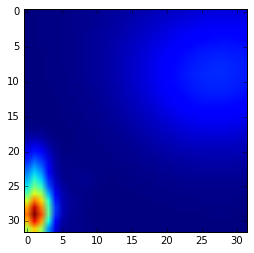

In [28]:
plt.imshow(x_img[0,0])

In [5]:
def evaluate_random_retinas(event_names,y,n_retinas,seeds = None,batch_size = 8):
    
    if seeds is None:
        seeds = [None]*n_retinas #Nonecat
        
    retinas,retina_params =  zip(*map(random_retina, seeds))

        
    #batch_size = a number of retinas computed in a single batch
    n_batches = (len(retinas)-1)/batch_size +1
    
    reports = []
    
    for b_i in range(n_batches):
        #concatenate all lines among grids in batches of 6 retinas each but for optionally the last one
        
        batch_retinas = retinas[batch_size*b_i:batch_size*(b_i+1)]


        X_batch = retinize_events(event_names,data_path,
                                  retina_views= batch_retinas,
                                  max_hits_block=5000,report_rate=100)
        
        X_batch = X_batch.reshape([len(X_batch),len(batch_retinas),-1])
        
        X_retinas = [X_batch[:,r_i] for r_i in range(X_batch.shape[1])]
    
        reports += evaluate_retinas(X_retinas,y)

    return retinas,retina_params,reports
    
    
    

In [6]:
df_ref = pd.DataFrame.from_csv(reference_df_path,index_col=None)

In [ ]:
def next_batch_name(path,postfix=".npy"):
    index = 0
    while True:
        candidate = os.path.join(path,"batch"+str(index)+postfix)
        
        if not os.path.exists(candidate):
            return candidate
        index +=1


In [ ]:
while True:
    res=evaluate_random_retinas(df_ref.X_filename[:1000],
                            df_ref.relevant_decay_count[:1000]>0,
                            n_retinas= 32)

    retinas,retina_params,reports=res

    auc_threshold = 0.525
    saved_retinas = {}


    aucs = [report["auc test"] for report in reports]
    for retina,params,report,auc in zip(retinas,retina_params,reports,aucs):

        if auc > auc_threshold:
            saved_retinas[params]= (retina,report)



    import pickle
    with open(next_batch_name(os.path.join("data",experiment_name)),'w') as fout:
        pickle.dump(saved_retinas,fout)

